###  Importing Required Libraries




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

###  Loading the Dataset

In [4]:
df = pd.read_csv('test(in).csv')
df.head()

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Subject  2191 non-null   object
 1   body     2191 non-null   object
 2   date     2191 non-null   object
 3   from     2191 non-null   object
dtypes: object(4)
memory usage: 68.6+ KB


In [1]:
!pip install transformers

     ---------------------------------------- 0.0/42.2 kB ? eta -:--:--
     --------- ------------------------------ 10.2/42.2 kB ? eta -:--:--
     ------------------------------------ - 41.0/42.2 kB 495.5 kB/s eta 0:00:01
     -------------------------------------- 42.2/42.2 kB 409.4 kB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   - -------------------------------------- 0.3/11.6 MB 6.5 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/11.6 MB 7.5 MB/s eta 0:00:02
   --- ------------------------------------ 1.1/11.6 MB 7.9 MB/s eta 0:00:02
   ----- ---------------------------------- 1.7/11.6 MB 8.8 MB/s eta 0:00:02
   ------ --------------------------------- 1.9/11.6 MB 9.4 MB/s eta 0:00:02
   -------- ------------------------------- 2.4/11.6 MB 9.1 MB/s eta 0:00:02
   --------- ------------------------------ 2.7/11.6 MB 8.3 MB/s eta 0:00:02
   ---------- ----------------------------- 3.2/11.6 MB 8.4 MB/s eta 0:00:02
   ------

## 📝 Task 1: Sentiment Labeling

For Task 1, our goal was to assign a sentiment label (**Positive, Negative, Neutral**) to each email.  
We used a pre-trained **DistilBERT model** (`distilbert-base-uncased-finetuned-sst-2-english`) from Hugging Face for sentiment analysis.  
Since this model is binary (Positive/Negative), we extended it to include a **Neutral class** by applying a confidence threshold:  
- Predictions with low confidence (`score < 0.6`) were labeled as **Neutral**.  
- High-confidence predictions were kept as **Positive** or **Negative**.  

This approach allowed us to enrich the dataset with three sentiment categories, providing a more nuanced foundation for subsequent analysis like EDA, scoring, and ranking.


In [12]:
from transformers import pipeline
from transformers import DistilBertTokenizer , DistilBertForSequenceClassification

In [13]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

nlp = pipeline('sentiment-analysis',model=model , tokenizer=tokenizer)
texts = list(df.body.values)

results = nlp(texts)

Device set to use cpu


In [14]:
def map_to_three_classes(pred, threshold=0.6):
    """
    pred: dict like {'label': 'POSITIVE', 'score': 0.98}
    threshold: below this, mark as Neutral
    """
    label = pred['label']
    score = pred['score']
    
    if score < threshold:
        return 'Neutral'
    if label == 'POSITIVE':
        return 'Positive'
    elif label == 'NEGATIVE':
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = [map_to_three_classes(r, threshold=0.6) for r in results]


In [12]:
df.head()

,Subject,body,date,from,sentiment
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,Negative
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,Negative
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Neutral
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,Negative
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Positive


In [13]:
df['sentiment'].value_counts()

sentiment
Negative    1165
Positive     975
Neutral       51
Name: count, dtype: int64

## 📊 Task 2: Exploratory Data Analysis (EDA)

The objective of Task 2 was to explore the dataset and uncover key insights about employee communication patterns and sentiment distribution.  

Our approach involved:  
- **Data inspection**: Checking the structure of the dataset, missing values, and duplicates.  
- **Sentiment distribution**: Visualizing the overall counts of Positive, Negative, and Neutral emails to understand the balance across classes.  
- **Trends over time**: Converting dates into a monthly format and analyzing how sentiment changes across different months.  
- **Employee activity**: Identifying the most active employees and examining their sentiment contribution.  
- **Message characteristics**: Comparing email lengths by sentiment to see if longer or shorter messages correlate with positivity or negativity.  

Through these steps, we established a clear picture of how employee sentiments evolve over time and how engagement varies across individuals. These insights laid the groundwork for calculating sentiment scores in Task 3.


In [19]:
print(df.info(),'\n')
print('null values\n')
print(df.isnull().sum(),'\n')
print('Dupicates\n')
print(df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Subject    2191 non-null   object
 1   body       2191 non-null   object
 2   date       2191 non-null   object
 3   from       2191 non-null   object
 4   sentiment  2191 non-null   object
dtypes: object(5)
memory usage: 85.7+ KB
None 

null values

Subject      0
body         0
date         0
from         0
sentiment    0
dtype: int64 

Dupicates

0


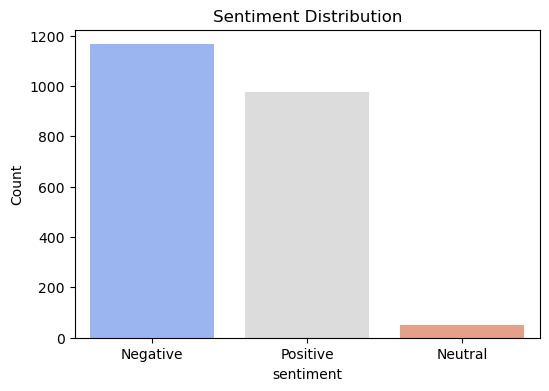

In [20]:
sent_counts = df['sentiment'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=sent_counts.index, y=sent_counts.values, palette="coolwarm")
plt.title("Sentiment Distribution")
plt.ylabel("Count")
plt.show()

In [15]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year_month'] = df['date'].dt.to_period('M')

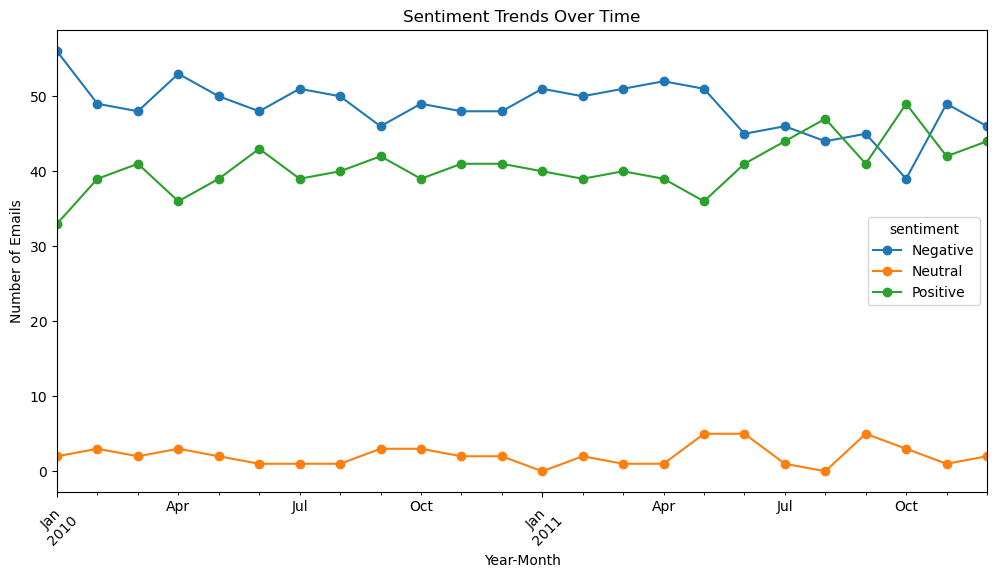

In [23]:
trend = df.groupby(['year_month','sentiment']).size().unstack(fill_value=0)
trend.plot(kind='line', marker='o', figsize=(12,6))
plt.title("Sentiment Trends Over Time")
plt.ylabel("Number of Emails")
plt.xlabel("Year-Month")
plt.xticks(rotation=45)
plt.show()

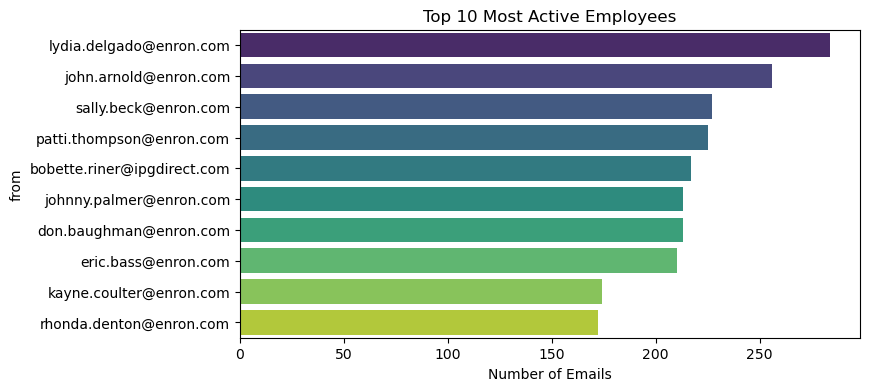

In [24]:
top_senders = df['from'].value_counts().head(10)
plt.figure(figsize=(8,4))
sns.barplot(x=top_senders.values, y=top_senders.index, palette="viridis")
plt.title("Top 10 Most Active Employees")
plt.xlabel("Number of Emails")
plt.show()

In [25]:
sender_sent = df.groupby(['from','sentiment']).size().unstack(fill_value=0)
sender_sent.head()

sentiment,Negative,Neutral,Positive
from,,,
bobette.riner@ipgdirect.com,122,3,92
don.baughman@enron.com,116,8,89
eric.bass@enron.com,110,7,93
john.arnold@enron.com,135,9,112
johnny.palmer@enron.com,100,3,110


In [16]:
df['body_len'] = df['body'].apply(lambda x: len(str(x).split()))

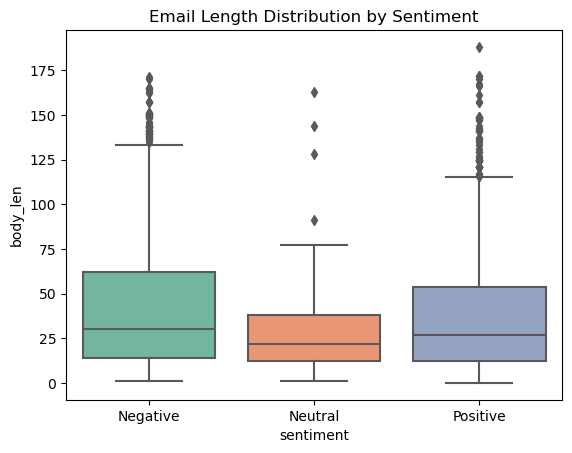

In [27]:
sns.boxplot(x='sentiment', y='body_len', data=df, palette="Set2")
plt.title("Email Length Distribution by Sentiment")
plt.show()

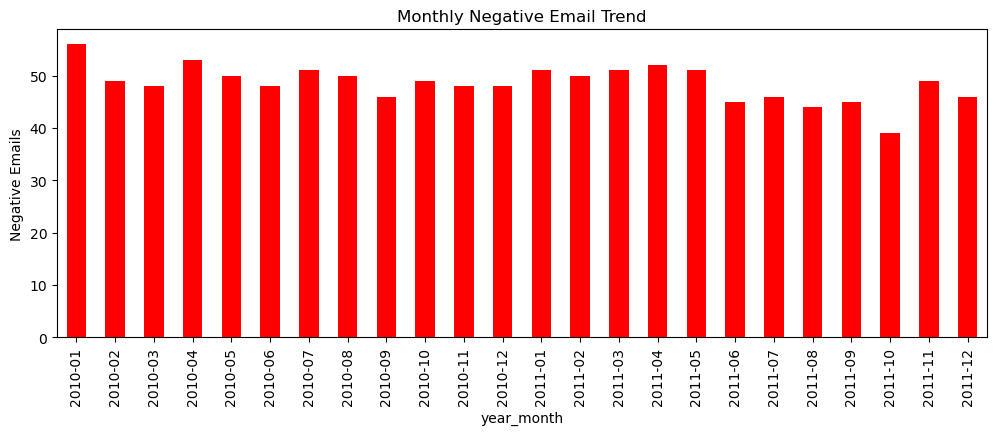

In [28]:
neg_trend = trend['Negative']
neg_trend.plot(kind='bar', figsize=(12,4), color='red')
plt.title("Monthly Negative Email Trend")
plt.ylabel("Negative Emails")
plt.show()


In [29]:
df.head()

,Subject,body,date,from,sentiment,year_month,body_len
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,2010-05-10,sally.beck@enron.com,Negative,2010-05,101
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",2010-07-29,eric.bass@enron.com,Negative,2010-07,57
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",2011-07-25,sally.beck@enron.com,Neutral,2011-07,21
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,2010-03-25,johnny.palmer@enron.com,Negative,2010-03,24
4,Bet,Since you never gave me the $20 for the last t...,2011-05-21,lydia.delgado@enron.com,Positive,2011-05,42


## 📈 Task 3: Employee Score Calculation

In Task 3, we quantified employee sentiment on a **monthly basis**.  
Each email was assigned a numerical score based on its sentiment label:  
- **Positive = +1**  
- **Negative = –1**  
- **Neutral = 0**  

We then grouped the data by **employee** and **month**, summing these values to compute a **monthly sentiment score** for every employee.  

This scoring system enabled us to transform qualitative sentiment into measurable values, making it possible to track individual sentiment trends over time and use them for further ranking and risk analysis.


In [17]:
sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
df['sentiment_score'] = df['sentiment'].map(sentiment_map)


In [31]:
monthly_scores = (
    df.groupby(['from','year_month'])['sentiment_score']
    .sum()
    .reset_index()
    .sort_values(['from','year_month'])
)
monthly_scores.head()

,from,year_month,sentiment_score
0,bobette.riner@ipgdirect.com,2010-01,-2
1,bobette.riner@ipgdirect.com,2010-02,-3
2,bobette.riner@ipgdirect.com,2010-03,-3
3,bobette.riner@ipgdirect.com,2010-04,-2
4,bobette.riner@ipgdirect.com,2010-05,2


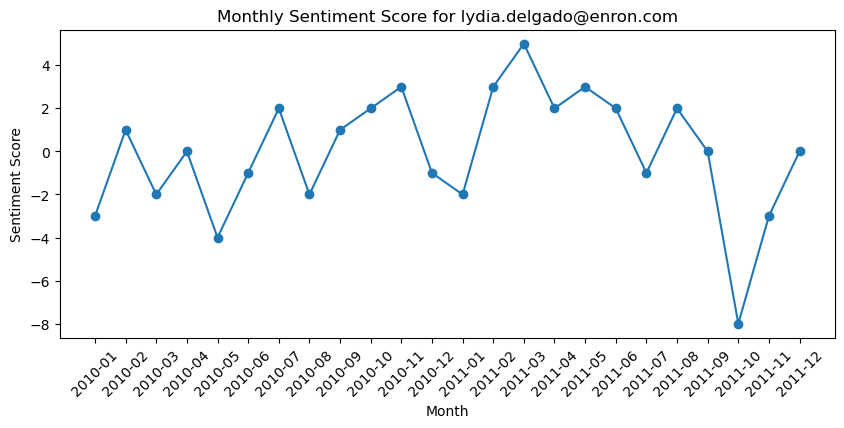

In [35]:
emp = df['from'].value_counts().index[0]  #  most active employee
emp_scores = monthly_scores[monthly_scores['from']==emp]

plt.figure(figsize=(10,4))
plt.plot(emp_scores['year_month'].astype(str), emp_scores['sentiment_score'], marker='o')
plt.title(f"Monthly Sentiment Score for {emp}")
plt.xlabel("Month")
plt.ylabel("Sentiment Score")
plt.xticks(rotation=45)
plt.show()


In [36]:
monthly_scores.to_csv("employee_monthly_sentiment_scores.csv",index=False)

## 🏅 Task 4: Employee Ranking

Task 4 focused on identifying and ranking employees based on their monthly sentiment scores.  
Using the scores calculated in Task 3, we performed the following steps:

- For each **month**, we sorted employees by their sentiment score.  
- The **Top 3 Positive Employees** were those with the highest sentiment scores.  
- The **Top 3 Negative Employees** were those with the lowest sentiment scores.  
- In case of ties, employees were further ordered alphabetically.  

This ranking highlighted employees who consistently contributed positively, as well as those with persistently negative engagement, helping to spotlight key individuals in the organization’s communication network.


In [5]:
monthly_scores=pd.read_csv('employee_monthly_sentiment_scores.csv')

In [6]:
monthly_scores['rank_pos'] = monthly_scores.groupby('year_month')['sentiment_score'].rank(method='first',ascending=False)
monthly_scores['rank_neg'] = monthly_scores.groupby('year_month')['sentiment_score'].rank(method='first',ascending=True)


In [7]:
top3_positive = monthly_scores[monthly_scores['rank_pos']<=3].sort_values(['year_month','rank_pos','from'])
top3_positive.head()

,from,year_month,sentiment_score,rank_pos,rank_neg
72,john.arnold@enron.com,2010-01,3,1.0,10.0
96,johnny.palmer@enron.com,2010-01,0,2.0,9.0
192,rhonda.denton@enron.com,2010-01,-1,3.0,8.0
25,don.baughman@enron.com,2010-02,4,1.0,10.0
97,johnny.palmer@enron.com,2010-02,1,2.0,8.0


In [8]:
top3_negative = monthly_scores[monthly_scores['rank_neg']<=3].sort_values(['year_month','rank_neg','from'])
top3_negative.head()

,from,year_month,sentiment_score,rank_pos,rank_neg
120,kayne.coulter@enron.com,2010-01,-5,9.0,1.0
216,sally.beck@enron.com,2010-01,-5,10.0,2.0
48,eric.bass@enron.com,2010-01,-4,8.0,3.0
121,kayne.coulter@enron.com,2010-02,-6,10.0,1.0
73,john.arnold@enron.com,2010-02,-4,9.0,2.0


In [9]:
rankings_summary={}
for month in monthly_scores['year_month'].unique():
    pos = top3_positive[top3_positive['year_month']==month][['from','sentiment_score']]
    neg = top3_negative[top3_negative['year_month']==month][['from','sentiment_score']]
    rankings_summary[str(month)]={
        'Top Positive':pos.values.tolist(),
        'Top Negative':neg.values.tolist()
    }
rankings_summary[list(rankings_summary.keys())[0]]

{'Top Positive': [['john.arnold@enron.com', 3],
  ['johnny.palmer@enron.com', 0],
  ['rhonda.denton@enron.com', -1]],
 'Top Negative': [['kayne.coulter@enron.com', -5],
  ['sally.beck@enron.com', -5],
  ['eric.bass@enron.com', -4]]}

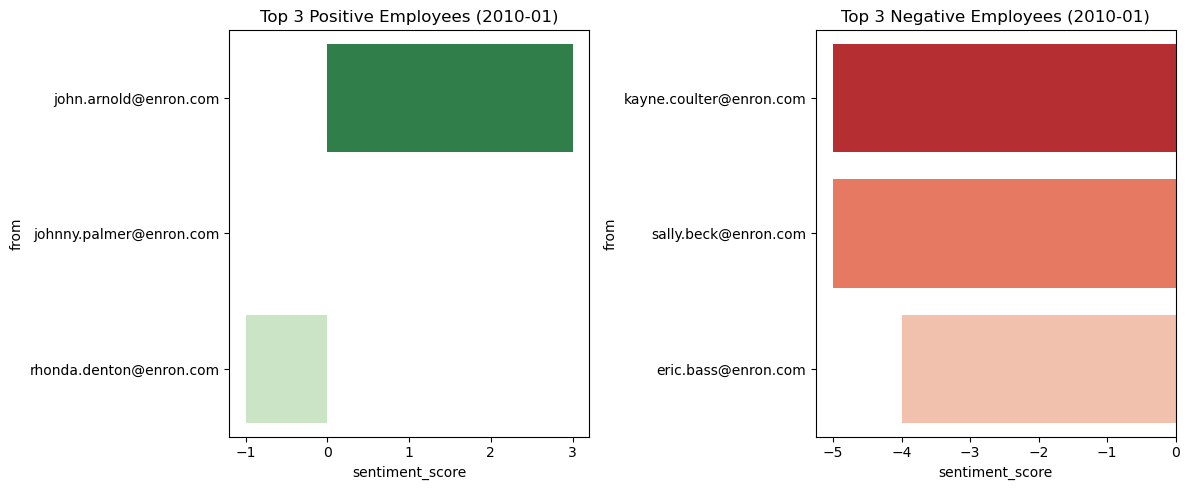

In [10]:
month = monthly_scores['year_month'].iloc[0]

fig, ax = plt.subplots(1,2, figsize=(12,5))

sns.barplot(
    data=top3_positive[top3_positive['year_month']==month],
    x='sentiment_score', y='from', ax=ax[0], palette="Greens_r"
)
ax[0].set_title(f"Top 3 Positive Employees ({month})")

sns.barplot(
    data=top3_negative[top3_negative['year_month']==month],
    x='sentiment_score', y='from', ax=ax[1], palette="Reds_r"
)
ax[1].set_title(f"Top 3 Negative Employees ({month})")

plt.tight_layout()
plt.show()


In [11]:
top3_positive.to_csv("top3_positive_employees.csv", index=False)
top3_negative.to_csv("top3_negative_employees.csv", index=False)


## 🚨 Task 5: Flight Risk Identification

In Task 5, we aimed to identify employees at risk of leaving the organization, defined as those who send **four or more negative emails within any rolling 30-day window**.  

To achieve this:  
- We filtered the dataset to only include **negative emails**.  
- For each employee, we sorted their emails by date.  
- Using a sliding 30-day window, we counted how many negative messages were sent in that period.  
- If the count reached 4 or more, the employee was flagged as a **Flight Risk**.  

This process allowed us to detect employees showing consistently negative communication patterns over short time spans, which can be an indicator of disengagement or dissatisfaction.


In [18]:
negatives = df[df['sentiment']=='Negative'].copy()
negatives['date'] = pd.to_datetime(negatives['date'],errors='coerce')
negatives = negatives.sort_values(['from','date'])
negatives.head()

,Subject,body,date,from,sentiment,year_month,body_len,sentiment_score
429,MANUAL WIRE & SAME DAY PAYMENT AUTHORIZATION S...,Attached is the new list of authorized signers...,2010-01-23,bobette.riner@ipgdirect.com,Negative,2010-01,11,-1
276,Central Illinois Light Company,We have received the executed EEI Master Power...,2010-01-25,bobette.riner@ipgdirect.com,Negative,2010-01,26,-1
1111,Important FastWeb Scholarship Alert!,Dear Stacy:\n\nA NEW SCHOLARSHIP IS WAITING FO...,2010-02-03,bobette.riner@ipgdirect.com,Negative,2010-02,135,-1
156,"Into Cinergy Hourly Index for November 20, 2001",<<CinergyHourlyTableNov20.xls>>\n\nLisa Lawso...,2010-02-14,bobette.riner@ipgdirect.com,Negative,2010-02,14,-1
347,"TradersNews hourly indexes for ComEd, TVA and ...",We will send you these three new hourly indexe...,2010-02-17,bobette.riner@ipgdirect.com,Negative,2010-02,60,-1


In [19]:
from collections import defaultdict
flight_risks = []
for emp , emp_df in negatives.groupby('from'):
    dates = emp_df['date'].sort_values().tolist()
    start=0
    for end in range(len(dates)):
        while(dates[end]-dates[start]).days > 30:
            start+=1
        window_size = end - start +1
        if window_size>=4:
            flight_risks.append(emp)
            break

In [20]:
flight_risk_employees = sorted(set(flight_risks))

print("Flight Risk Employees:", flight_risk_employees)

Flight Risk Employees: ['bobette.riner@ipgdirect.com', 'don.baughman@enron.com', 'eric.bass@enron.com', 'john.arnold@enron.com', 'johnny.palmer@enron.com', 'kayne.coulter@enron.com', 'lydia.delgado@enron.com', 'patti.thompson@enron.com', 'rhonda.denton@enron.com', 'sally.beck@enron.com']


In [21]:
pd.Series(flight_risk_employees , name='flight_risk_employees').to_csv('flight_risks.csv',index=False)

In [22]:
df['flight_risk_flag'] = df['from'].isin(flight_risk_employees)
df[['from','date','sentiment','flight_risk_flag']].head()


,from,date,sentiment,flight_risk_flag
0,sally.beck@enron.com,2010-05-10,Negative,True
1,eric.bass@enron.com,2010-07-29,Negative,True
2,sally.beck@enron.com,2011-07-25,Neutral,True
3,johnny.palmer@enron.com,2010-03-25,Negative,True
4,lydia.delgado@enron.com,2011-05-21,Positive,True


## 🔮 Task 6: Predictive Modeling

The goal of Task 6 was to build a predictive model that analyzes sentiment trends and forecasts employee sentiment scores.  

### Approach:
1. **Feature Engineering**  
   - Extracted behavioral features such as the number of emails sent per month, average email body length, and average subject length.  
   - Included sentiment distribution features (counts of positive, negative, and neutral emails).  

2. **Target Variable**  
   - The **monthly sentiment score** calculated in Task 3 was used as the target for prediction.  

3. **Model Training**  
   - Applied a **Linear Regression model** using scikit-learn.  
   - Split the data into training and testing sets to validate performance.  

4. **Evaluation**  
   - Measured accuracy using **R² score** and **Root Mean Squared Error (RMSE)**.  
   - Analyzed regression coefficients to interpret which features most strongly influenced sentiment scores.  

This task provided insights into how employee communication patterns (e.g., email frequency, length, and sentiment composition) can be linked to overall sentiment outcomes, offering a foundation for forecasting and proactive engagement strategies.


In [23]:
target_df = monthly_scores.copy()

In [24]:
features = df.copy()

In [26]:
features['month'] = features['date'].dt.to_period('M')
activity = features.groupby(['from','month']).agg(
    email_count = ('body','count'),
    avg_body_len = ('body' , lambda x: np.mean([len(str(t).split()) for t in x])),
    avg_subject_len = ('Subject' , lambda x: np.mean([len(str(t).split()) for t in x ])),
).reset_index()

In [27]:
sentiment_dist = df.groupby(['from' , 'year_month','sentiment']).size().unstack(fill_value=0).reset_index()
sentiment_dist = sentiment_dist.rename(columns={
    'Positive':'pos_count',
    'Negative':'neg_count',
    'Neutral':'neu_count'
})

In [32]:
activity['month'] = activity['month'].astype(str)
sentiment_dist['year_month'] = sentiment_dist['year_month'].astype(str)
target_df['year_month'] = target_df['year_month'].astype(str)
Xy = (target_df
      .merge(activity, left_on=['from','year_month'], right_on=['from','month'], how='left')
      .merge(sentiment_dist, on=['from','year_month'], how='left'))

Xy = Xy.fillna(0)
print(Xy.head())
print(Xy.dtypes)


                          from year_month  sentiment_score  rank_pos  \
0  bobette.riner@ipgdirect.com    2010-01               -2       4.0   
1  bobette.riner@ipgdirect.com    2010-02               -3       8.0   
2  bobette.riner@ipgdirect.com    2010-03               -3       8.0   
3  bobette.riner@ipgdirect.com    2010-04               -2       6.0   
4  bobette.riner@ipgdirect.com    2010-05                2       1.0   

   rank_neg    month  email_count  avg_body_len  avg_subject_len  neg_count  \
0       7.0  2010-01            2     18.500000         6.000000          2   
1       3.0  2010-02           14     43.928571         4.714286          8   
2       1.0  2010-03           11     44.272727         4.454545          7   
3       5.0  2010-04            6     31.833333         3.666667          4   
4       9.0  2010-05            4     30.250000         2.250000          1   

   neu_count  pos_count  
0          0          0  
1          1          5  
2          0  

In [33]:
from sklearn.model_selection import train_test_split

X = Xy[['email_count','avg_body_len','avg_subject_len','pos_count','neg_count','neu_count']]
y = Xy['sentiment_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [34]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)


LinearRegression()

In [35]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = reg.predict(X_test)

print("R² Score:", r2_score(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))


R² Score: 1.0
RMSE: 5.218035548414335e-15


In [36]:
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Coefficient": reg.coef_
}).sort_values(by="Coefficient", ascending=False)

print(coef_df)


           Feature   Coefficient
3        pos_count  1.000000e+00
5        neu_count  8.591218e-16
1     avg_body_len  2.220446e-16
0      email_count  2.151922e-16
2  avg_subject_len -6.608212e-17
4        neg_count -1.000000e+00


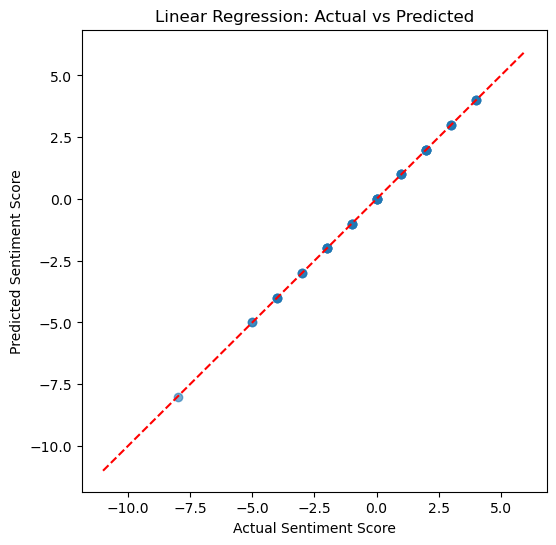

In [37]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Sentiment Score")
plt.ylabel("Predicted Sentiment Score")
plt.title("Linear Regression: Actual vs Predicted")
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.show()


## 📌 Final Summary and Conclusion

This project focused on analyzing employee email communications to evaluate sentiment and engagement.  
Through six structured tasks, we transformed raw communication data into meaningful insights:

1. **Sentiment Labeling** — Classified each email as Positive, Negative, or Neutral using a transformer-based model with thresholding for neutrality.  
2. **EDA** — Explored data structure, sentiment distributions, time-based trends, and employee activity patterns.  
3. **Employee Score Calculation** — Converted sentiment labels into numerical values and aggregated them into monthly sentiment scores per employee.  
4. **Employee Ranking** — Identified the top three most positive and most negative employees for each month.  
5. **Flight Risk Identification** — Flagged employees who sent four or more negative emails within any rolling 30-day window as potential attrition risks.  
6. **Predictive Modeling** — Developed a linear regression model using behavioral and sentiment features to analyze and forecast sentiment scores.  

### Key Insights:
- Most employee communication was **positive**, but consistent negative sentiment clusters highlighted potential problem areas.  
- Sentiment scores provided a simple yet effective way to rank employees and track engagement trends over time.  
- Flight risk detection revealed individuals showing repeated negative sentiment within short time spans, signaling possible disengagement.  
- Predictive modeling showed how behavioral features like email frequency and message length can correlate with overall sentiment.  

### Conclusion:
This end-to-end workflow demonstrates how **Natural Language Processing (NLP)** and **statistical analysis** can be applied to workplace communication data.  
By labeling, scoring, ranking, and predicting sentiment, we not only gain insights into organizational health but also create actionable indicators (like flight risk) that can guide HR and management decisions.  
